# Final Project Report

* Class: DS 5100
* Student Name: Terrance Luangrath
* Student Net ID: vwy4sa
* This URL: https://github.com/tksluangrath/montecarlo/blob/main/DS51200_FinalProjectTemplate.ipynb

# Instructions

Follow the instructions in the Final Project isntructions notebook and put evidence of your work in this notebook.

Total points for each subsection under **Deliverables** and **Scenarios** are given in parentheses.

Breakdowns of points within subsections are specified within subsection instructions as bulleted lists.

This project is worth **50 points**.

# Deliverables

## The Monte Carlo Module (10)

- URL included, appropriately named (1).
- Includes all three specified classes (3).
- Includes at least all 12 specified methods (6; .5 each).

Put the URL to your GitHub repo here.

Repo URL: https://github.com/tksluangrath/montecarlo

Paste a copy of your module here.

NOTE: Paste as text, not as code. Use triple backticks to wrap your code blocks.

```python
import numpy as np
import pandas as pd

class Die():
    
    def __init__(self, faces):
        """Initialize the Die class
        
        Input:
            faces (numpy.ndarray): Array of faces with distinct values.
            
        Raises:
            TypeError: If input is not a Numpy array.
            ValueError: If values are not distinct.
        """
        # Check if faces is a NumPy array
        if not isinstance(faces, np.ndarray):
            raise TypeError('Must be a NumPy array')
        
        # Check if all values are distinct
        if len(np.unique(faces)) != len(faces):
            raise ValueError('All values in the array must be distinct')
            
        # Initializes weights
        weights = np.ones_like(faces, dtype=float)
        
        # Create private dataframe
        self.dataframe = pd.DataFrame({'weights':weights}, index = faces)
        
    
    def change_weight(self, face_value, new_weight):
        """Change weight of a specific face.
        
        Input:
            face_value (int): The face need to update.
            new_weight (int, float, str): The new weight value.
        
        Raises:
            IndexError: If face_value is not in the die.
            TypeError: If the new weight is not a numeric type.
            ValueError: If the new weight is invalid.
        """
        # Check for existing faces
        if face_value not in self.dataframe.index:
            raise IndexError(f'Face value, {face_value}, is not found')

        # Handle numeric weights
        if isinstance(new_weight, (int, float)):
            self.dataframe.loc[face_value, 'weights'] = float(new_weight)
        # Handle string weights
        elif isinstance(new_weight, str):
            try:
                self.dataframe.loc[face_value, 'weights'] = float(new_weight)
            except ValueError:
                raise TypeError('Weight must be numeric (int or float)')
        else:
            raise TypeError(f'Weights must be numeric (int or float)')
            
    
    def roll(self, dice_rolls=1):
        """Roll the dice one or more times.
        
        Input:
            dice_rolls (int): Number of times to roll the die (default = 1).
            
        Returns:
            list: Outcomes of each roll.
        
        Raises:
            TypeError: If times is not an integer.
            ValueError: If times is less than 1.
        """
        # Validate input
        if not isinstance(dice_rolls, int):
            raise TypeError("Number of rolls must be an integer.")
        if dice_rolls < 1:
            raise ValueError("Number of rolls must be positive.")
        
        # Get weighted probobality                     
        weights = self.dataframe['weights'].values
        normalized_weights = weights / weights.sum()
        
        # Perform random rolls
        outcomes = np.random.choice(
            self.dataframe.index.values,
            size=dice_rolls,
            p=normalized_weights
        )
        
        return list(outcomes)
    
    def get_data(self):
        """Returns a copy of the die's current dataframe.
            
        Returns:
            pandas.DataFrame: Copy of the die's faces and weights
        """
        return self.dataframe.copy()
```

```python
from .die import Die
import pandas as pd
import numpy as np

class Game():
    
    def __init__(self, dice):
        """Initialize a Game with a list of dice.
        
        Input:
            dice (list): List of Die objects with identical faces.
        
        Raises:
            TypeError: If any element in dice is not a Die object.
            ValueError: If dice don't have identical faces.
        """
        if not isinstance(dice, list) or len(dice) < 1:
            raise ValueError('Must be a list of dice')
        
        # Check if all elements are Die class
        for die in dice:
            if not isinstance(die, Die):
                raise TypeError('All elements must be a Die object')
        
        # Check identical faces
        first = set(dice[0].get_data().index)
        for die in dice[1:]:
            if set(die.get_data().index) != first:
                raise ValueError('All dice must have identical faces')
        
        self.dice = dice
        self.results = None
        
    
    def play(self, rolls):
        """Play the game by rolling the dice.
        
        Input:
            rolls (int): Number of times to roll each die.
        
        Raises:
            TypeError: If rolls is not an integer.
            ValueError: If rolls is less than 1.
        """
        if not isinstance(rolls, int):
            raise TypeError('Number of rolls must be an integer.')
        if rolls < 1:
            raise ValueError('Number of rolls must be a positive integer.')
        
        # Play the game and save as results DataFrame
        results = {}
        for i, die in enumerate(self.dice):
            results[i] = die.roll(rolls)

        self.results = pd.DataFrame(results)
        
    def show_results(self, form='wide'):
        """Show the most recent game results.
        
        Input:
            form (str): 'wide' or 'narrow' format.
            
        Returns:
            pandas.DataFrame: Results in requested format.
            
        Raises:
            ValueError: If no results available or invalid format.
        """
        if self.results is None:
            raise ValueError("Play the game first.")
        
        if form == 'wide':
            return self.results.copy()
        elif form == 'narrow':
            narrow_df = self.results.stack().reset_index()
            narrow_df.columns = ['Rolls', 'Die', 'Face']
            return narrow_df.set_index(['Rolls', 'Die'])
        else:
            raise ValueError('Format must be either \'wide\' or \'narrow\'')
```

```python
from .game import Game
import numpy as np
import pandas as pd

class Analyzer():
    
    def __init__(self, game):
        """Initialize the Analyzer class with a Game object.
        
        Inputs:
            game: A Game object to analyze.
            
        Raises:
            ValueError: If input is not a Game object.
        """
        if not isinstance(game, Game):
            raise ValueError('Input must be a Game object.')
        self.game = game
        self.results = None
        
    def _check_results(self):
        """Private method to check if results are available."""
        if self.game.results is None:
            raise ValueError("No game results available. Play the game first.")
        self.results = self.game.show_results()
    
    
    def jackpot(self):
        """Count the number of jackpot rolls (all faces are identical).
        
        Returns:
            int: Number of jackpot.
        
        Raises:
            ValueError: If no game was play.
        """
        self._check_results()
        return int((self.results.nunique(axis=1) == 1).sum())
    
    
    def face_counts_per_roll(self):
        """Count occurrences of each face in each rolls.
        
        Returns:
            pd.DataFrame: Wide format with roll numbers, face counts
            
        Raises:
            ValueError: If no game was play
        """
        self._check_results()
        counts_df = self.results.apply(pd.Series.value_counts, axis=1).fillna(0).astype(int)
        face_order = self.game.dice[0].get_data().index.tolist()
        return counts_df.reindex(columns = face_order, fill_value = 0)
        
        
    def combo_count(self):
        """Count distinct combination of faces.
        
        Returns:
            pd.DataFrame: MultiIndex of combinations with counts.
        
        Raises:
            ValueError: If no game was play.
        """
        self._check_results()    
        combos = self.game.results.apply(lambda row: tuple(sorted(row)), axis=1)
        counts = combos.value_counts().reset_index()
        counts.columns = ['Combination', 'Counts']
        counts = counts.set_index('Combination')
        counts.index = pd.MultiIndex.from_tuples(counts.index, 
                                                 names=[f'{i}' for i in range(self.game.results.shape[1])]
                                                )
        return counts
    
    
    def permutation_count(self):
        """Count distinct permutations of faces.
        
        Returns:
            pd.DataFrame: MultiIndex of permutations with counts.
            
        Raises:
            ValueError: If no game was play.
        """
        self._check_results()
        perms = self.game.results.apply(lambda row: tuple(row), axis=1)
        counts = perms.value_counts().rename('Counts').to_frame()
        counts.index = pd.MultiIndex.from_tuples(
            counts.index,
            names=[f'{i}' for i in range(self.game.results.shape[1])])
        return counts
```

## Unitest Module (2)

Paste a copy of your test module below.

NOTE: Paste as text, not as code. Use triple backticks to wrap your code blocks.

- All methods have at least one test method (1).
- Each method employs one of Unittest's Assert methods (1).

```python
import unittest
import numpy as np
import pandas as pd
from montecarlo.die import Die
from montecarlo.game import Game
from montecarlo.analyzer import Analyzer


class DieTestSuite(unittest.TestCase):
    
    def test_01_init_valid(self):
        """Test initialization with valid numeric and string faces."""
        # Valid input (numeric)
        faces_numeric = np.array([1, 2, 3, 4, 5, 6])
        dice = Die(faces_numeric)
        
        # Valid input (strings)
        faces_strings = np.array(['a', 'b', 'c', 'd'])
        dice = Die(faces_strings)
        
        
    def test_02_init_invalid_array(self):
        """Test initialization with invalid data types (should raise TypeError)."""
        # Invalid input (failed array)
        faces_list = [1, 2, 3, 4, 5, 6]
        with self.assertRaises(TypeError):
            dice = Die(faces_list)
    
    
    def test_03_init_invalid_distinct(self):
        """Test initialization with non-distinct values (should raise ValueError)."""
        # Invalid input (non-distinct values)
        with self.assertRaises(ValueError):
            dice = Die(np.array([1, 2, 2, 3]))
    
    
    def test_04_change_weight_valid_input(self):
        """Test changing weight with valid numeric input."""
        die = Die(np.array([1, 2, 3]))
        die.change_weight(2, 1.5) # Valid float
        self.assertEqual(die.dataframe.loc[2, 'weights'], 1.5)
        
        die.change_weight(1, 2)  # Valid integer
        self.assertEqual(die.dataframe.loc[1, 'weights'], 2.0)
        
        
    def test_05_change_weight_valid_string_input(self):
        """Test changing weight with valid string intput."""
        die = Die(np.array([1, 2, 3]))
        die.change_weight(2, "2") # String integer
        self.assertEqual(die.dataframe.loc[2, 'weights'], 2.0)
        
        die.change_weight(1, "1.5") # String float
        self.assertEqual(die.dataframe.loc[1, 'weights'], 1.5)
    
    
    def test_06_change_weight_invalid_face(self):
        """Test changing weight on non-existing face."""
        die = Die(np.array([1, 2, 3]))
        with self.assertRaises(IndexError):
            die.change_weight(10, 2)
            
            
    def test_07_invalid_datatypes(self):
        """Test changing weight with non-numeric values."""
        die = Die(np.array([1, 2, 3]))
        with self.assertRaises(TypeError):
            die.change_weight(3, "3..14")
            
            
    def test_08_roll_valid(self):
        """Test rolls with valid integer input."""
        die = Die(np.array([1, 2, 3]))
        
        # Test default roll
        result = die.roll()
        self.assertEqual(len(result), 1)
        
        # Test multiple rolls
        results = die.roll(10)
        self.assertEqual(len(results), 10)
        
        
    def test_09_roll_invalid(self):
        """Test rolls with invalid input."""
        die = Die(np.array([1, 2, 3]))
        
        with self.assertRaises(TypeError):
            die.roll("ten") # String input
        with self.assertRaises(TypeError):
            die.roll(2.0) # Float input
        with self.assertRaises(ValueError):
            die.roll(0) # Non-positive integer input
        with self.assertRaises(ValueError):
            die.roll(-1) # Negative integer input
    
    
    def test_10_get_data(self):
        """Test get_data() method."""
        faces = [1, 2, 3]
        die = Die(np.array([1, 2, 3]))
        die.change_weight(1, 0.4)
        df = die.get_data()
        
        # Verify Structure
        self.assertEqual(df.shape, (3, 1))
        self.assertTrue(np.array_equal(df.index.values, faces))
        self.assertTrue(np.array_equal(df['weights'].values, [0.4, 1.0, 1.0]))
        
        
class GameTestSuite(unittest.TestCase):
    
    def test_01_init(self):
        """Test initalization with valid input."""
        die1 = Die(np.array([1, 2, 3]))
        die2 = Die(np.array([1, 2, 3]))
        
        game = Game([die1, die2])
        self.assertEqual(len(game.dice), 2)
    
    
    def test_02_mismatch_faces(self):
        """Test initalization with mismatch die object."""
        die1 = Die(np.array([1, 2, 3]))
        die2 = Die(np.array(['A', 'B', 'C', 'D']))
        
        with self.assertRaises(ValueError):
            Game([die1, die2])
    
    
    def test_03_invalid_die_type(self):
        """Test initalization with non-Die object."""
        die1 = Die(np.array([1, 2, 3]))
        
        with self.assertRaises(TypeError):
            Game([die1, "die2"])
            
            
    def test_04_empty_list(self):
        """Test initalization with empty list."""
        with self.assertRaises(ValueError):
            Game([])
    
    
    def test_05_play_valid(self):
        """Test play() with valid rolls."""
        die1 = Die(np.array([1, 2, 3, 4, 5, 6]))
        die2 = Die(np.array([1, 2, 3, 4, 5, 6]))
        game1 = Game([die1, die2])
        
        game1.play(3)
        
        
    def test_06_play_invalid(self):
        """Test play() with invaild roll counts."""
        die1 = Die(np.array([1, 2, 3, 4, 5, 6]))
        die2 = Die(np.array([1, 2, 3, 4, 5, 6]))
        game1 = Game([die1, die2])
        
        with self.assertRaises(ValueError):
            game1.play(0)
            
        with self.assertRaises(ValueError):
            game1.play(-1)
            
        with self.assertRaises(TypeError):
            game1.play(3.14)
            
        with self.assertRaises(TypeError):
            game1.play("5")
            
            
    def test_07_show_results_wide_format(self):
        """Test show_results() with wide format."""
        die1 = Die(np.array([1, 2, 3, 4, 5, 6]))
        die2 = Die(np.array([1, 2, 3, 4, 5, 6]))
        game1 = Game([die1, die2])
        game1.play(3)
            
        results = game1.show_results('wide')
        
        # Verify structure
        self.assertIsInstance(results, pd.DataFrame)
        self.assertEqual(results.shape, (3, 2))
        
        # Verify all values are valid faces
        vaild_faces = {1, 2, 3, 4, 5, 6}
        for die in results.columns:
            self.assertTrue(all(face in vaild_faces for face in results[die]))
        
        
    def test_08_show_results_narrow_format(self):
        """Test show_results() with narrow format."""
        die1 = Die(np.array([1, 2, 3, 4, 5, 6]))
        die2 = Die(np.array([1, 2, 3, 4, 5, 6]))
        game1 = Game([die1, die2])
        game1.play(3)
        
        results = game1.show_results('narrow')
        
        # Verify structure
        self.assertIsInstance(results, pd.DataFrame)
        self.assertEqual(results.shape, (6, 1))
        
        # Verify all values are valid faces
        vaild_faces = {1, 2, 3, 4, 5, 6}
        for die in results.columns:
            self.assertTrue(all(face in vaild_faces for face in results[die]))
           
        
    def test_09_show_results_no_play(self):
        """ Test show_results() with 0 play."""
        die1 = Die(np.array([1, 2, 3, 4, 5, 6]))
        die2 = Die(np.array([1, 2, 3, 4, 5, 6]))
        game1 = Game([die1, die2])
        
        with self.assertRaises(ValueError):
            game1.show_results('wide')
            
        with self.assertRaises(ValueError):
            game1.show_results('narrow')
            
            
    def test_10_show_results_invalid(self):
        """Test show_results() with invalid input."""
        die1 = Die(np.array([1, 2, 3, 4, 5, 6]))
        die2 = Die(np.array([1, 2, 3, 4, 5, 6]))
        game1 = Game([die1, die2])
        game1.play(3)
        
        with self.assertRaises(ValueError):
            game1.show_results(4)
            
            
    def test_11_show_results_default(self):
        """Test show_results() with default format (wide)."""
        die1 = Die(np.array([1, 2, 3, 4, 5, 6]))
        die2 = Die(np.array([1, 2, 3, 4, 5, 6]))
        game1 = Game([die1, die2])
        game1.play(3)
            
        results = game1.show_results()
        
        # Verify structure
        self.assertIsInstance(results, pd.DataFrame)
        self.assertEqual(results.shape, (3, 2))
        
        # Verify all values are valid faces
        vaild_faces = {1, 2, 3, 4, 5, 6}
        for die in results.columns:
            self.assertTrue(all(face in vaild_faces for face in results[die]))

            
class AnalyzerTestSuite(unittest.TestCase):
    
    def test_01_int_valid(self):
        """Test initalization with valid input."""
        faces = np.array([1, 2, 3, 4, 5, 6])
        die1 = Die(faces)
        die2 = Die(faces)
        die3 = Die(faces)
        
        game1 = Game([die1, die2, die3])
        game1.play(100)
        
        game2 = Game([die1, die2, die3])
        
        analyzer1 = Analyzer(game1)
        analyzer2 = Analyzer(game2)
        
        self.assertIsInstance(analyzer1, Analyzer)
        self.assertIsInstance(analyzer1, Analyzer)   
    
    
    def test_02_int_invalid(self):
        """Test initalization with invalid input."""
        faces = np.array([1, 2, 3, 4, 5, 6])
        die1 = Die(faces)
        
        with self.assertRaises(ValueError):
            Analyzer(die1)
    
    
    def test_03_jackpot_valid(self):
        """Test jackpot method with valid input."""
        faces = np.array([1, 2, 3, 4, 5, 6])
        die1 = Die(faces)
        die2 = Die(faces)
        die3 = Die(faces)
        
        game1 = Game([die1, die2, die3])
        game1.play(100)
                
        analyzer1 = Analyzer(game1)
        
        # Verify output
        jackpots = analyzer1.jackpot()
        self.assertIsInstance(jackpots, int)
        
        # Force a jackpot
        analyzer1.game.results.iloc[0] = [1, 1, 1]
        self.assertGreaterEqual(analyzer1.jackpot(), 1)
        
        
    def test_04_jackpot_invalid(self):
        """Test jackpot method with no game played."""
        faces = np.array([1, 2, 3, 4, 5, 6])
        die1 = Die(faces)
        die2 = Die(faces)
        die3 = Die(faces)
        
        game1 = Game([die1, die2, die3])
        
        analyzer1 = Analyzer(game1)
        
        with self.assertRaises(ValueError):
            analyzer1.jackpot()
         
        
    def test_05_faces_count_valid(self):
        """Test face counts method."""
        faces = np.array([1, 2, 3, 4, 5, 6])
        die1 = Die(faces)
        die2 = Die(faces)
        die3 = Die(faces)
        
        game1 = Game([die1, die2, die3])
        game1.play(100)
        
        analyzer1 = Analyzer(game1)
        counts = analyzer1.face_counts_per_roll()
        
        # Verify the structure
        self.assertIsInstance(counts, pd.DataFrame)
        self.assertEqual(counts.shape, (100, 6))
        self.assertListEqual(list(counts.columns), [1, 2, 3, 4, 5, 6])
        self.assertTrue((counts.sum(axis=1) == 3).all())
    
    
    def test_06_faces_count_invalid(self):
        """Test face counts method with no game played."""
        faces = np.array([1, 2, 3, 4, 5, 6])
        die1 = Die(faces)
        die2 = Die(faces)
        die3 = Die(faces)
        
        game1 = Game([die1, die2, die3])
        analyzer1 = Analyzer(game1)
        
        with self.assertRaises(ValueError):
            analyzer1.face_counts_per_roll()        
            
            
    def test_07_combo_count_valid(self):
        """Test combo counts method with valid game."""
        faces = np.array([1, 2, 3, 4, 5, 6])
        die1 = Die(faces)
        die2 = Die(faces)
        die3 = Die(faces)
        
        game1 = Game([die1, die2, die3])
        game1.play(100)
        
        analyzer1 = Analyzer(game1)
        combos = analyzer1.combo_count()
        
        # Verify the structure
        self.assertIsInstance(combos, pd.DataFrame)
        self.assertIsInstance(combos.index, pd.MultiIndex)
        self.assertEqual(combos.index.names, ['0', '1', '2'])
        self.assertTrue((combos['Counts'] > 0).all())
        
        
    def test_08_combo_count_invalid(self):
        """Test combo counts method with no game played."""
        faces = np.array([1, 2, 3, 4, 5, 6])
        die1 = Die(faces)
        die2 = Die(faces)
        die3 = Die(faces)
        
        game1 = Game([die1, die2, die3])
        analyzer1 = Analyzer(game1)
        
        with self.assertRaises(ValueError):
            analyzer1.combo_count()
            
            
    def test_09_permutation_count_invalid(self):
        """Test permutation counts method with no game played."""
        faces = np.array([1, 2, 3, 4, 5, 6])
        die1 = Die(faces)
        die2 = Die(faces)
        die3 = Die(faces)
        
        game1 = Game([die1, die2, die3])
        analyzer1 = Analyzer(game1)
        
        with self.assertRaises(ValueError):
            analyzer1.permutation_count()
            
            
    def test_10_permutation_count_valid(self):
        """Test permutation with valid game played."""
        faces = np.array([1, 2, 3, 4, 5, 6])
        die1 = Die(faces)
        die2 = Die(faces)
        die3 = Die(faces)

        # Test normal case with random rolls
        game1 = Game([die1, die2, die3])
        game1.play(100)
        analyzer1 = Analyzer(game1)
        perms = analyzer1.permutation_count()

        # Verify MultiIndex structure
        self.assertGreater(len(perms), 0)
        self.assertLessEqual(len(perms), 100)
        self.assertIsInstance(perms.index, pd.MultiIndex)
        self.assertEqual(perms.index.names, ['0', '1', '2'])

        # Verify counts sum to number of rolls
        self.assertEqual(perms['Counts'].sum(), 100) 
        
        
    def test_11_permutation_count_jackpot(self):
        """Test permutation count results."""
        faces = np.array([1, 2, 3, 4, 5, 6])
        die1 = Die(faces)
        die2 = Die(faces)
        die3 = Die(faces)

        # Force a jacpot (all rolls = 1)
        game = Game([die1, die2, die3])
        game.play(100)
        game.results.iloc[:, :] = 1 

        analyzer = Analyzer(game)
        perms = analyzer.permutation_count()

        # Only one permutation expected
        self.assertEqual(len(perms), 1)
        self.assertEqual(perms.iloc[0]['Counts'], 100)

        
if __name__ == '__main__':
    unittest.main(verbosity=3)
```

## Unittest Results (3)

Put a copy of the results of running your tests from the command line here.

Again, paste as text using triple backticks.

- All 12 specified methods return OK (3; .25 each).

## Import (1)

Import your module here. This import should refer to the code in your package directory.

- Module successuflly imported (1).

In [6]:
import montecarlo

## Help Docs (4)

Show your docstring documentation by applying `help()` to your imported module.

- All methods have a docstring (3; .25 each).
- All classes have a docstring (1; .33 each).

In [7]:
help(montecarlo)

Help on package montecarlo:

NAME
    montecarlo

PACKAGE CONTENTS
    analyzer
    die
    game

FILE
    /sfs/gpfs/tardis/home/vwy4sa/Documents/MSDS/DS5100/DS5100-vwy4sa/ds5100_final_project_files/montecarlo/montecarlo/__init__.py




In [8]:
from montecarlo.die import Die

help(Die)

Help on class Die in module montecarlo.die:

class Die(builtins.object)
 |  Die(faces)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, faces)
 |      Initialize the Die class
 |      
 |      Input:
 |          faces (numpy.ndarray): Array of faces with distinct values.
 |          
 |      Raises:
 |          TypeError: If input is not a Numpy array.
 |          ValueError: If values are not distinct.
 |  
 |  change_weight(self, face_value, new_weight)
 |      Change weight of a specific face.
 |      
 |      Input:
 |          face_value (int): The face need to update.
 |          new_weight (int, float, str): The new weight value.
 |      
 |      Raises:
 |          IndexError: If face_value is not in the die.
 |          TypeError: If the new weight is not a numeric type.
 |          ValueError: If the new weight is invalid.
 |  
 |  get_data(self)
 |      Returns a copy of the die's current dataframe.
 |          
 |      Returns:
 |          pandas.DataFrame: Copy of th

In [9]:
from montecarlo.game import Game

help(Game)

Help on class Game in module montecarlo.game:

class Game(builtins.object)
 |  Game(dice)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, dice)
 |      Initialize a Game with a list of dice.
 |      
 |      Input:
 |          dice (list): List of Die objects with identical faces.
 |      
 |      Raises:
 |          TypeError: If any element in dice is not a Die object.
 |          ValueError: If dice don't have identical faces.
 |  
 |  play(self, rolls)
 |      Play the game by rolling the dice.
 |      
 |      Input:
 |          rolls (int): Number of times to roll each die.
 |      
 |      Raises:
 |          TypeError: If rolls is not an integer.
 |          ValueError: If rolls is less than 1.
 |  
 |  show_results(self, form='wide')
 |      Show the most recent game results.
 |      
 |      Input:
 |          form (str): 'wide' or 'narrow' format.
 |          
 |      Returns:
 |          pandas.DataFrame: Results in requested format.
 |          
 |      Raises:
 |  

In [10]:
from montecarlo.analyzer import Analyzer

help(Analyzer)

Help on class Analyzer in module montecarlo.analyzer:

class Analyzer(builtins.object)
 |  Analyzer(game)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, game)
 |      Initialize the Analyzer class with a Game object.
 |      
 |      Inputs:
 |          game: A Game object to analyze.
 |          
 |      Raises:
 |          ValueError: If input is not a Game object.
 |  
 |  combo_count(self)
 |      Count distinct combination of faces.
 |      
 |      Returns:
 |          pd.DataFrame: MultiIndex of combinations with counts.
 |      
 |      Raises:
 |          ValueError: If no game was play.
 |  
 |  face_counts_per_roll(self)
 |      Count occurrences of each face in each rolls.
 |      
 |      Returns:
 |          pd.DataFrame: Wide format with roll numbers, face counts
 |          
 |      Raises:
 |          ValueError: If no game was play
 |  
 |  jackpot(self)
 |      Count the number of jackpot rolls (all faces are identical).
 |      
 |      Returns:
 |          

## `README.md` File (3)

Provide link to the README.md file of your project's repo.

- Metadata section or info present (1).
- Synopsis section showing how each class is called (1). (All must be included.)
- API section listing all classes and methods (1). (All must be included.)

URL: https://github.com/tksluangrath/montecarlo/blob/main/README.md

## Successful installation (2)

Put a screenshot or paste a copy of a terminal session where you successfully install your module with pip.

If pasting text, use a preformatted text block to show the results.

- Installed with `pip` (1).
- Successfully installed message appears (1).

bash-4.4$pip install git+https://github.com/tksluangrath/montecarlo.git \
Defaulting to user installation because normal site-packages is not writeable \
Collecting git+https://github.com/tksluangrath/montecarlo.git \
  Cloning https://github.com/tksluangrath/montecarlo.git to /tmp/pip-req-build-qig67d9q \
  Running command git clone --filter=blob:none --quiet https://github.com/tksluangrath/montecarlo.git /tmp/pip-req-build-qig67d9q \
  Resolved https://github.com/tksluangrath/montecarlo.git to commit 675f98a1d581ebe621dc21793640bf9f31c82994 \
  Preparing metadata (setup.py) ... done \
Requirement already satisfied: numpy in /apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages (from montecarlo==1.1) (1.24.4) \
Requirement already satisfied: pandas in /apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages (from montecarlo==1.1) (2.0.3) \
Requirement already satisfied: pytest in /home/vwy4sa/.local/lib/python3.11/site-packages (from montecarlo==1.1) (8.3.5) \ 
Requirement already satisfied: python-dateutil>=2.8.2 in /apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages (from pandas->montecarlo==1.1) (2.8.2) \
Requirement already satisfied: pytz>=2020.1 in /apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages (from pandas->montecarlo==1.1) (2023.3) \
Requirement already satisfied: tzdata>=2022.1 in /apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages (from pandas->montecarlo==1.1) (2023.3) \
Requirement already satisfied: iniconfig in /home/vwy4sa/.local/lib/python3.11/site-packages (from pytest->montecarlo==1.1) (2.1.0) \
Requirement already satisfied: packaging in /apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages (from pytest->montecarlo==1.1) (23.1) \
Requirement already satisfied: pluggy<2,>=1.5 in /home/vwy4sa/.local/lib/python3.11/site-packages (from pytest->montecarlo==1.1) (1.5.0) \
Requirement already satisfied: six>=1.5 in /apps/software/standard/core/jupyterlab/3.6.3-py3.11/lib/python3.11/site-packages (from python-dateutil>=2.8.2->pandas->montecarlo==1.1) (1.16.0) \
Building wheels for collected packages: montecarlo \
  Building wheel for montecarlo (setup.py) ... done \
  Created wheel for montecarlo: filename=montecarlo-1.1-py3-none-any.whl size=7216 sha256=7d97b7720a342bcb814dc3a66d5d0a0cceb83cd8ef51047b4f4b5c9925beacb8 \
  Stored in directory: /tmp/pip-ephem-wheel-cache-igfq6hmb/wheels/8f/a1/07/0e88d3584c54cb3f27c31b969d6eb0ac73ec409d0ad77d20d4 \ 
Successfully built montecarlo \
Installing collected packages: montecarlo \
  Attempting uninstall: montecarlo \
    Found existing installation: montecarlo 1.1 \
    Uninstalling montecarlo-1.1: \
      Successfully uninstalled montecarlo-1.1 \
Successfully installed montecarlo-1.1 

# Scenarios

Use code blocks to perform the tasks for each scenario.

Be sure the outputs are visible before submitting.

## Scenario 1: A 2-headed Coin (9)

Task 1. Create a fair coin (with faces $H$ and $T$) and one unfair coin in which one of the faces has a weight of $5$ and the others $1$.

- Fair coin created (1).
- Unfair coin created with weight as specified (1).

In [11]:
from montecarlo.die import Die
from montecarlo.game import Game

import numpy as np
from montecarlo.die import Die

fair_coin = Die(np.array(['H', 'T']))
print(f'Fair coin created:\n{fair_coin.get_data()}')

unfair_coin = Die(np.array(['H', 'T']))
unfair_coin.change_weight('H', 5)
unfair_coin.change_weight('T', 1)
print(f'\nUnfair coin created:\n{unfair_coin.get_data()}')

Fair coin created:
   weights
H      1.0
T      1.0

Unfair coin created:
   weights
H      5.0
T      1.0


Task 2. Play a game of $1000$ flips with two fair dice.

- Play method called correclty and without error (1).

In [12]:
fair_game = Game([fair_coin, fair_coin])
fair_game.play(1000)

results = fair_game.show_results()
print(results)

     0  1
0    T  T
1    H  T
2    H  H
3    T  H
4    T  H
..  .. ..
995  H  H
996  T  T
997  T  H
998  T  H
999  H  T

[1000 rows x 2 columns]


Task 3. Play another game (using a new Game object) of $1000$ flips, this time using two unfair dice and one fair die. For the second unfair die, you can use the same die object twice in the list of dice you pass to the Game object.

- New game object created (1).
- Play method called correclty and without error (1).

In [13]:
unfair_coin = Die(np.array(['H', 'T']))
unfair_coin.change_weight('H', 5)
unfair_coin.change_weight('T', 1)

unfair_game = Game([unfair_coin, unfair_coin, fair_coin])
unfair_game.play(1000)

results = unfair_game.show_results()
print(results)

     0  1  2
0    H  H  T
1    T  H  T
2    H  T  T
3    H  H  H
4    H  T  H
..  .. .. ..
995  H  T  H
996  H  H  H
997  T  H  H
998  H  H  T
999  H  H  H

[1000 rows x 3 columns]


Task 4. For each game, use an Analyzer object to determine the raw frequency of jackpots — i.e. getting either all $H$s or all $T$s.

- Analyzer objecs instantiated for both games (1).
- Raw frequencies reported for both (1).

In [14]:
fair_analyzer = Analyzer(fair_game)
unfair_analyzer = Analyzer(unfair_game)

fair_jackpot_count = fair_analyzer.jackpot()
unfair_jackpot_count = unfair_analyzer.jackpot()

print(f'Fair game jackpot count: {fair_jackpot_count}')
print(f'Unfair game jackpot count: {unfair_jackpot_count}')

Fair game jackpot count: 507
Unfair game jackpot count: 371


Task 5. For each analyzer, compute relative frequency as the number of jackpots over the total number of rolls.

- Both relative frequencies computed (1).

In [15]:
print(f'Fair game relative jackpot frequency: {fair_jackpot_count / 1000}')
print(f'Unfair game relative jackpot frequency: {unfair_jackpot_count / 1000}')

Fair game relative jackpot frequency: 0.507
Unfair game relative jackpot frequency: 0.371


Task 6. Show your results, comparing the two relative frequencies, in a simple bar chart.

- Bar chart plotted and correct (1).

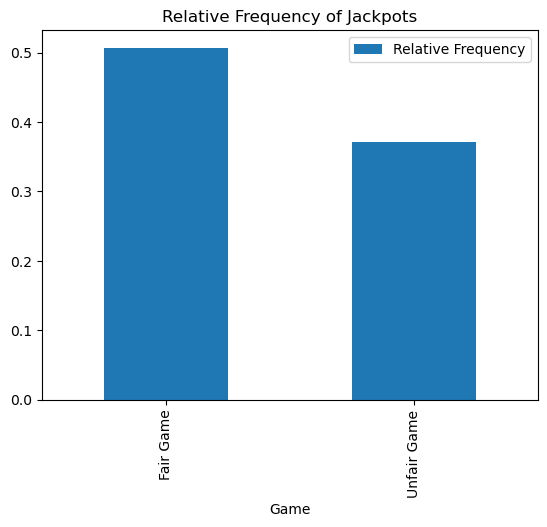

In [16]:
import pandas as pd

df = pd.DataFrame({
    'Game': ['Fair Game', 'Unfair Game'],
    'Relative Frequency': [fair_jackpot_count / 1000, unfair_jackpot_count / 1000]
})

df.plot(
    kind='bar',
    x='Game',
    y='Relative Frequency',
    title='Relative Frequency of Jackpots'
);



## Scenario 2: A 6-sided Die (9)

Task 1. Create three dice, each with six sides having the faces 1 through 6.

- Three die objects created (1).

In [17]:
die1 = Die(np.array([1, 2, 3, 4, 5, 6]))
die2 = Die(np.array([1, 2, 3, 4, 5, 6]))
die3 = Die(np.array([1, 2, 3, 4, 5, 6]))

Task 2. Convert one of the dice to an unfair one by weighting the face $6$ five times more than the other weights (i.e. it has weight of 5 and the others a weight of 1 each).

- Unfair die created with proper call to weight change method (1).

In [18]:
die1.change_weight(6, 5)

Task 3. Convert another of the dice to be unfair by weighting the face $1$ five times more than the others.

- Unfair die created with proper call to weight change method (1).

In [19]:
die2.change_weight(1, 5)

Task 4. Play a game of $10000$ rolls with $5$ fair dice.

- Game class properly instantiated (1). 
- Play method called properly (1).

In [20]:
fair_die1 = Die(np.array([1, 2, 3, 4, 5, 6]))
fair_die2 = Die(np.array([1, 2, 3, 4, 5, 6]))
fair_die3 = Die(np.array([1, 2, 3, 4, 5, 6]))
fair_die4 = Die(np.array([1, 2, 3, 4, 5, 6]))
fair_die5 = Die(np.array([1, 2, 3, 4, 5, 6]))


fair_game = Game([fair_die1, fair_die2, fair_die3, fair_die4, fair_die5])
fair_game.play(10000)

results = fair_game.show_results()
print(results)

      0  1  2  3  4
0     3  1  2  5  5
1     6  4  1  5  4
2     4  1  6  2  1
3     2  4  1  2  4
4     1  6  5  2  4
...  .. .. .. .. ..
9995  2  4  2  5  4
9996  2  1  6  3  1
9997  5  1  3  5  5
9998  6  3  1  5  5
9999  2  1  4  6  4

[10000 rows x 5 columns]


Task 5. Play another game of $10000$ rolls, this time with $2$ unfair dice, one as defined in steps #2 and #3 respectively, and $3$ fair dice.

- Game class properly instantiated (1). 
- Play method called properly (1).

In [21]:
unfair_game = Game([die1, die2, fair_die3, fair_die4, fair_die5])
unfair_game.play(10000)

results = unfair_game.show_results()
print(results)

      0  1  2  3  4
0     1  1  1  2  4
1     6  5  4  5  4
2     6  1  1  1  3
3     1  2  5  4  4
4     4  1  5  2  6
...  .. .. .. .. ..
9995  5  1  6  4  4
9996  2  1  5  6  5
9997  6  4  1  5  6
9998  6  1  5  5  3
9999  6  6  1  5  6

[10000 rows x 5 columns]


Task 6. For each game, use an Analyzer object to determine the relative frequency of jackpots and show your results, comparing the two relative frequencies, in a simple bar chart.

- Jackpot methods called (1).
- Graph produced (1).

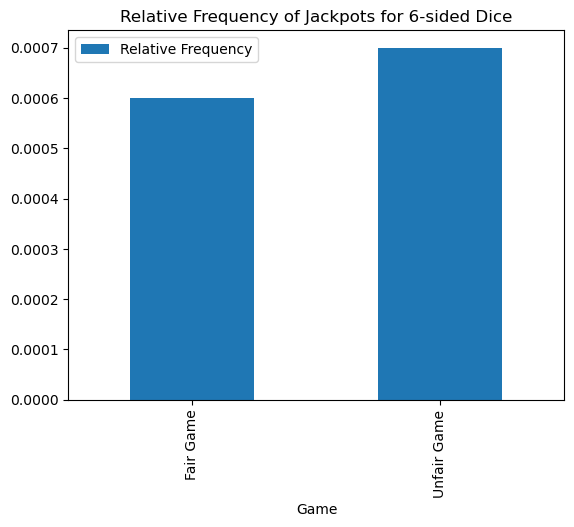

In [22]:
fair_analyzer = Analyzer(fair_game)
unfair_analyzer = Analyzer(unfair_game)

fair_jackpot_freq = fair_analyzer.jackpot() / 10000
unfair_analyzer_freq = unfair_analyzer.jackpot() / 10000

df_die = pd.DataFrame({
    'Game': ['Fair Game', 'Unfair Game'],
    'Relative Frequency': [fair_jackpot_freq, unfair_analyzer_freq]
})

df_die.plot(
    kind='bar',
    x='Game',
    y='Relative Frequency',
    title='Relative Frequency of Jackpots for 6-sided Dice'
);


## Scenario 3: Letters of the Alphabet (7)

Task 1. Create a "die" of letters from $A$ to $Z$ with weights based on their frequency of usage as found in the data file `english_letters.txt`. Use the frequencies (i.e. raw counts) as weights.

- Die correctly instantiated with source file data (1).
- Weights properly applied using weight setting method (1).

In [23]:
import pandas as pd

df_letters = pd.read_csv('english_letters.txt',
                 delim_whitespace = True,
                 header = None,
                 names = ['Letter', 'Frequency']
                 )

letters_die = Die(np.array(df_letters['Letter'].tolist()))

for _, row in df_letters.iterrows():
    letters_die.change_weight(row['Letter'], row['Frequency'])

results = letters_die.get_data()
print(results)

       weights
E  529117365.0
T  390965105.0
A  374061888.0
O  326627740.0
I  320410057.0
N  313720540.0
S  294300210.0
R  277000841.0
H  216768975.0
L  183996130.0
D  169330528.0
C  138416451.0
U  117295780.0
M  110504544.0
F   95422055.0
G   91258980.0
P   90376747.0
W   79843664.0
Y   75294515.0
B   70195826.0
V   46337161.0
K   35373464.0
J    9613410.0
X    8369915.0
Z    4975847.0
Q    4550166.0


Task 2. Play a game involving $4$ of these dice with $1000$ rolls.

- Game play method properly called (1).

In [24]:
# Create 4 dice
letters_die1 = Die(np.array(df_letters['Letter'].tolist()))
letters_die2 = Die(np.array(df_letters['Letter'].tolist()))
letters_die3 = Die(np.array(df_letters['Letter'].tolist()))
letters_die4 = Die(np.array(df_letters['Letter'].tolist()))

# Change dice weights
for _, row in df_letters.iterrows():
    letters_die1.change_weight(row['Letter'], row['Frequency'])
    letters_die2.change_weight(row['Letter'], row['Frequency'])
    letters_die3.change_weight(row['Letter'], row['Frequency'])
    letters_die4.change_weight(row['Letter'], row['Frequency'])

# Play the game
letters_game1 = Game([letters_die1, letters_die2, letters_die3, letters_die4])
letters_game1.play(1000)

# Show the results
results1 = letters_game1.show_results()
print(results1)

     0  1  2  3
0    T  H  N  E
1    I  N  E  M
2    N  E  U  O
3    A  M  A  C
4    A  T  E  E
..  .. .. .. ..
995  A  S  I  E
996  Y  D  E  P
997  E  H  A  O
998  N  A  N  T
999  C  S  R  O

[1000 rows x 4 columns]


Task 3. Determine how many permutations in your results are actual English words, based on the vocabulary found in `scrabble_words.txt`.

- Use permutation method (1).
- Get count as difference between permutations and vocabulary (1).

In [25]:
# Analyze the game
letters_analyzer1 = Analyzer(letters_game1)
permutation1 = letters_analyzer1.permutation_count()

# Read given files        
df_scrabble = pd.read_csv('scrabble_words.txt',
                          header = None,
                          names = ['Words'])
df_scrabble['Words'].str.upper();
scrabble_words = set(df_scrabble['Words'])

# Combine each row into a single word
rolled_words1 = results1.apply(lambda row: ''.join(row), axis=1) 

# Check if rolled words are vaild in Scrabble words
valid_words1 = [word for word in rolled_words1 if word in scrabble_words] 

# Calculate the differences between permutation and voabulary
invalid_permutations = len(permutation1) - len(valid_words1)

print(
    f'The difference between permutations({len(permutation1)}) and '
    f'vocabulary({len(valid_words1)}) is {invalid_permutations}.'
)

The difference between permutations(994) and vocabulary(55) is 939.


Task 4. Repeat steps #2 and #3, this time with $5$ dice. How many actual words does this produce? Which produces more?

- Successfully repreats steps (1).
- Identifies parameter with most found words (1).

In [26]:
# Create the 5 die
letters_die5 = Die(np.array(df_letters['Letter'].tolist()))

# Change the weight
for _, row in df_letters.iterrows():
    letters_die5.change_weight(row['Letter'], row['Frequency'])

# Run the same scenario from 4 die with an additional die
letters_game2 = Game([letters_die1, letters_die2, letters_die3, letters_die4, letters_die5])
letters_game2.play(1000)
letters_analyzer2 = Analyzer(letters_game1)
permutation2 = letters_analyzer2.permutation_count()
results2 = letters_game2.show_results()
rolled_words2 = results2.apply(lambda row: ''.join(row), axis=1)
valid_words2 = [word for word in rolled_words2 if word in scrabble_words]
invalid_permutations2 = len(permutation2) - len(valid_words2)

print(
    f'The difference between permutations({len(permutation2)}) and '
    f'vocabulary({len(valid_words2)}) is {invalid_permutations2}.'
)

The difference between permutations(994) and vocabulary(5) is 989.
